# Classifying Handwritten Digits with Keras


In [ ]:
# Import necessary libraries
import tensorflow
from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import cv2

# Notebook specific functions to show graphs
%matplotlib inline

In [ ]:
# Some graphing functions we are going to use
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = img.reshape(28,28)
  plt.imshow(img, cmap=plt.get_cmap('gray'))

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')
  
  plt.xticks(range(10), class_names, rotation=45)

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/datasets
# Keras has a built in way to load the MNIST dataset, downloads the first time and then stores in file
# X's contain the images
# y's contain the labels for those images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# Look at the shapes of the data so we know what it looks like
# From below we can see that in the training dataset we have 60000 28x28 images
# and in our test dataset we have 10000 28x28 images. We also have the labels 
# for all of the images.
print('Shapes of training data:')
print('X:', X_train.shape)
print('y:', y_train.shape)
print()
print('Shapes of test data:')
print('X:', X_test.shape)
print('y:', y_test.shape)

Shapes of training data:
X: (60000, 28, 28)
y: (60000,)

Shapes of test data:
X: (10000, 28, 28)
y: (10000,)


In [ ]:
# For fun we can print out one of our images to see what the values look like
print(X_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

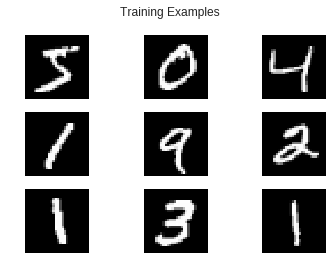

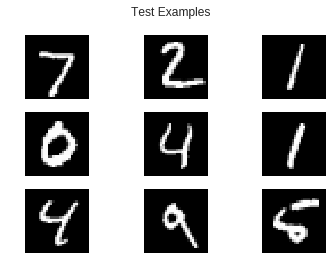

In [ ]:
# Plot the first few of images in training and test set
# Images are 28x28 pixels

for i in range(9):
  plt.subplot(330 + i+1)
  plt.axis('off')
  plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))

plt.suptitle('Training Examples')
plt.show()

for i in range(9):
  plt.subplot(330 + i+1)
  plt.axis('off')
  plt.imshow(X_test[i], cmap=plt.get_cmap('gray'))

plt.suptitle('Test Examples')
plt.show()


# Data Preprocessing
Let's begin by preprocessing our data so that it is in a more usuable form. Luckily MNIST is already cleaned (meaning there are no missing or bad values), but we want to adjust the data to be in a better form for our models.

In [ ]:
# For the training data we want to flatten out the 60000x28x28 to be 60000x784
# Instead of a 2d array for each image we know just have a flattened 784 1d array
num_pixels = X_train.shape[1] * X_train.shape[2]
print('Number of total pixels in each image:', num_pixels)

# Now reshape the train data to be 60000x784 and the test data to be 10000x784
# Also change the type for all values to be 'float32'
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

print()
print('Shape of training data:', X_train.shape)
print('Shape of testing data:', X_test.shape)

Number of total pixels in each image: 784

Shape of training data: (60000, 784)
Shape of testing data: (10000, 784)


In [ ]:
# The pixel values are 0-255 grayscale so normalize to be between 0 and 1. 
# Often normalizing these values helps the neural network to train faster/better.
X_train = X_train/255
X_test = X_test/255

# Set the number of classes
num_classes = 10
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Build a Neural Network

Let's build a neural network to classify our data.

In [ ]:
# Import classes that we need
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Baseline neural network
def baseline_neural_network():
    # Create the model
    # Sequential() creates a model where we will add layers layer by layer
    model = Sequential()
    
    # To our Sequential model we are adding a fully connected (dense) layer
    # The number of neurons in this layer will be 10 because of the first parameter to Dense()
    # The input to this layer (the input_dim) is 784 because we pass in one image at a time
    # The activation function we will use for this layer is 'relu'
    model.add(Dense(10, input_dim=num_pixels, activation='relu'))
    
    # Then we add another layer of size 10 (the number of classes)
    # We will use 'softmax' for the activation
    # This is our output layer. It will give us scores for each of our output labels.
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model using a certain loss function and optimizer
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________



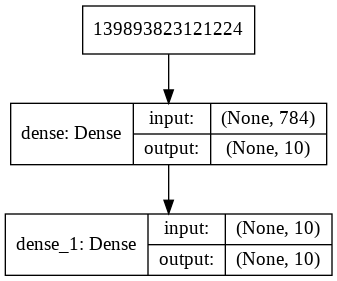

In [ ]:
# Create a new neural network
model = baseline_neural_network()

# Display a summary of our model
model.summary()

print()

# Display our model
utils.plot_model(model, show_shapes=True)
from IPython.display import Image
Image(retina=False, filename='model.png')

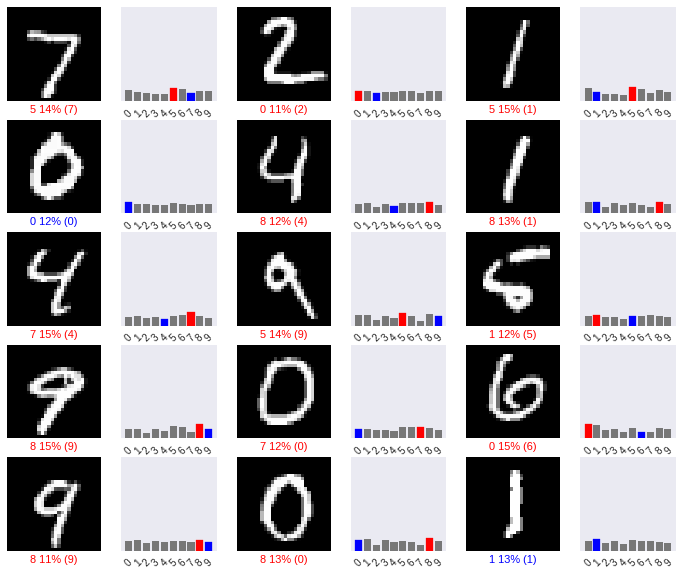

Example of what output from network looks like: [0.11543295 0.09893334 0.08446746 0.07425937 0.07057211 0.14109297
 0.12367436 0.07979874 0.10798233 0.10378633]


In [ ]:
# Predict with our untrained network
predictions = model.predict(X_train[:50])

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, y_test)
plt.show()

print('Example of what output from network looks like:', predictions[0])

In [ ]:
# The model is randomly initialized and hasn't learned anything. Train the model using the fit method.
# Epochs are how many times we train over the dataset
history = model.fit(X_train, y_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 7s 117us/sample - loss: 0.5137 - acc: 0.8535
Epoch 2/5
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2893 - acc: 0.9171
Epoch 3/5
60000/60000 [==============================] - 7s 115us/sample - loss: 0.2652 - acc: 0.9243
Epoch 4/5
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2525 - acc: 0.9283
Epoch 5/5
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2442 - acc: 0.9309


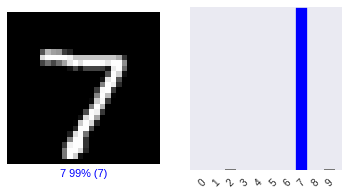

In [ ]:
# Now let's look at some of the predictions to see if it learned anything
predictions = model.predict(X_test)

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions, y_test)
plt.show()

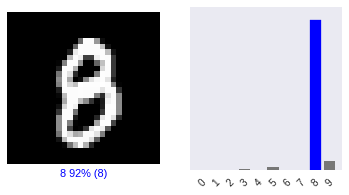

In [ ]:
i = 3492
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, y_test, X_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions, y_test)
plt.show()

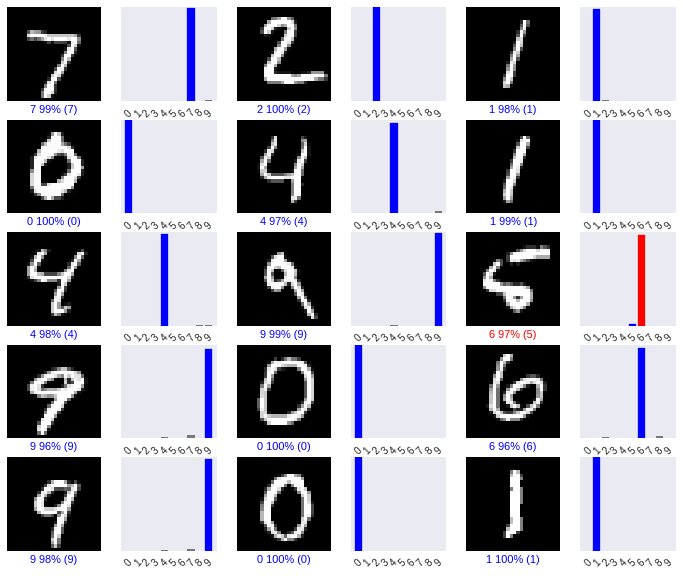

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, y_test)
plt.show()


In [ ]:
# Finally evaluate the model on all of the unseen data, which is our testing data
# Does our model generalize well?
scores = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

10000/10000 [==============================] - 1s 60us/sample - loss: 0.2473 - acc: 0.9303
Accuracy: 93.03%


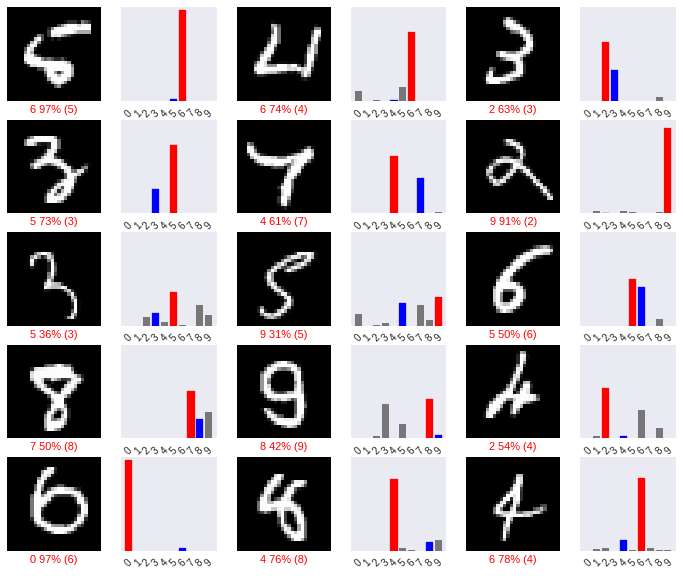

In [ ]:
# Get all incorrect predictions
incorrect = []
for i in range(10000):
  if y_test[i] != np.argmax(predictions[i]):
    incorrect.append(i)
    
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(incorrect[i], predictions, y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(incorrect[i], predictions, y_test)
plt.show()

# What if we go deeper?
![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT_PHJbF8QayQlOLscdtxg_wzK-kDQZSEgyWKm-b51uDQM4Nocr)

In [ ]:
def deeper_neural_network():
    # Create the model
    model = Sequential()
    
    # Add two layers, each with 784 neurons
    model.add(Dense(num_pixels, input_dim=num_pixels, activation='relu'))
    model.add(Dense(num_pixels, activation='relu'))
    model.add(Dense(num_pixels, activation='relu'))
    
    # Add output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile it in the same way
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Create our deeper neural network
model = deeper_neural_network()

model.summary()

# Let's train our model
history = model.fit(X_train, y_train, epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_3 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_4 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                7850      
Total params: 1,854,170
Trainable params: 1,854,170
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
60000/60000 [==============================] - 14s 227us/sample - loss: 0.1988 - acc: 0.9405
Epoch 2/5
60000/60000 [==============================] - 13s 224us/sample - loss: 0.0973 - acc: 0.9718
Epoch 3/5
60000/60000 [==============================] - 1

In [ ]:
scores = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

10000/10000 [==============================] - 1s 80us/sample - loss: 0.0979 - acc: 0.9745
Accuracy: 97.45%


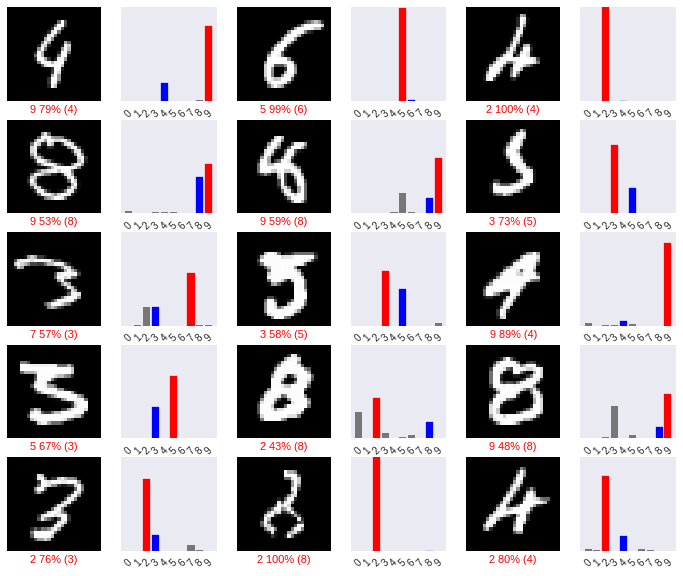

In [ ]:
# Get all incorrect predictions
predictions = model.predict(X_test)

incorrect = []
for i in range(10000):
  if y_test[i] != np.argmax(predictions[i]):
    incorrect.append(i)
    
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(incorrect[i], predictions, y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(incorrect[i], predictions, y_test)
plt.show()

# Classifying Your Own Digits
Create your own digit image in paint or a different painting program. You can find others online by searching for "paint online". Then upload your image.

Remember the image should be 28x28 pixels. The background should be black and the digit should be gray/white. If you use the paintbrush it will do white and grays inbetween.

In [ ]:
# Load in the image you created
from google.colab import files
img = files.upload()

In [ ]:

# Read in your file. Make sure you specify the right name.
image = cv2.imread('nine.png', 0)
print('Initial image shape:', image.shape)

# Reshape the input to be put into the model
image = image.reshape(1,784).astype('float32')
image = image/255
print('New image shape:', image.shape)

In [ ]:
# TODO Replace the number on the line below with the actual label
actual_label = 9

# Classify image
predictions = model.predict(image)

i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, np.array([actual_label]), np.array([image]))
plt.subplot(1,2,2)
plot_value_array(i, predictions, np.array([actual_label]))
plt.show()

# Something New
Let's try to classify something else.

Fashion MNIST is another dataset that you can drop in as a replacement for MNIST. It is a little more complicated than regular digits.

![alt text](https://tensorflow.org/images/fashion-mnist-sprite.png)

In [ ]:
# Load our new dataset and labels
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# These are the new class labels instead of 0-9
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Preprocess our data (reshape from 28x28 to 784) and normalize to between 0 and 1
X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')

X_train /= 255
X_test /= 255

In [ ]:
# TODO create your own network
def custom_neural_network():
    # Create the model
    model = Sequential()
    
    # TODO change the numbers of layers and nodes
    model.add(Dense(num_pixels, input_dim=num_pixels, activation='relu'))
    
    # Add output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile it in the same way
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Create our custom neural network
model = custom_neural_network()

# Let's train our model. TODO change number of epochs
history = model.fit(X_train, y_train, epochs=5)

In [ ]:
# Lots of room for improvement here
scores = model.evaluate(X_test, y_test)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
predictions = model.predict(X_test)

num_rows = 8
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols*2, 2*num_rows*2), dpi=80)
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, y_test)
plt.tight_layout()
plt.show()

In [ ]:
# Get all incorrect predictions
incorrect = []
for i in range(10000):
  if y_test[i] != np.argmax(predictions[i]):
    incorrect.append(i)
    
num_rows = 8
num_cols = 1
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols*2, 2*num_rows*2), dpi=80)
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(incorrect[i], predictions, y_test, X_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(incorrect[i], predictions, y_test)
plt.show()

# Where to go from here
There are many, many good tutorials online. A really good resource is https://www.tensorflow.org/learn.

Thanks!